# Notebook Instructions

1. All the <u>code and data files</u> used in this course are available in the downloadable unit of the <u>last section of this course</u>.
2. You can run the notebook document sequentially (one cell at a time) by pressing **shift + enter**. 
3. While a cell is running, a [*] is shown on the left. After the cell is run, the output will appear on the next line.

This course is based on specific versions of python packages. You can find the details of the packages in <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank" >this manual</a>.

# Time Series Momentum Strategy

In the previous notebook, you developed a time series momentum strategy on a single security. After completing this notebook, you will be to code and analyse time series momentum strategy across multiple asset classes.


In this notebook, you will perform the following steps:

1. [Read prices from CSV file](#read)
2. [Calculate strategy returns](#strategy_returns)
3. [Analyse strategy performance](#strategy_performance)<br>
    3.1 [Commodities](#commodities)<br>
    3.2 [Stock indices](#stocks)<br>
    3.3 [Currencies](#currencies)<br>
    3.4 [Treasuries](#bonds)<br>

<a id='read'></a> 
## Read prices from CSV file

In [1]:
# Import the package pandas as pd
import pandas as pd

# The data is stored in the directory 'data'
path = '../data/'

# Read the csv file using read_csv method of pandas
prices = pd.read_csv(path + 'security_prices_2000_2019.csv', index_col=0)

# Set the index to datetime
prices.index = pd.to_datetime(prices.index)

# Convert daily frequency to monthly frequency
prices = prices.asfreq('BM')
prices.tail()

,Gold,Silver,Crude Oil,Platinum,Corn,Sugar,Wheat,EUR-USD,USD-JPY,GBP-USD,...,GBP-EUR,S&P500,Dow Jones Industrial Average,NASDAQ,Russell 2000,TLT,TLH,IEF,IEI,SHY
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-30,143.750000,17.15,91.680000,88.040001,14.75,6.49,4.96,1.106195,106.438003,1.218650,...,1.10170,287.988037,259.769470,186.290970,147.207321,145.166946,150.266266,112.615204,126.135376,83.959152
2019-09-30,138.869995,15.92,90.720001,83.470001,15.18,6.67,5.30,1.089966,108.069000,1.228999,...,1.11732,293.591644,265.368683,188.000900,150.206024,141.276627,147.556595,111.279495,125.408447,83.846458
2019-10-31,142.429993,16.92,90.400002,87.930000,15.15,6.61,5.43,1.115449,108.789001,1.290173,...,1.15673,300.081421,266.821045,196.235474,154.285233,139.703934,146.834732,111.488579,125.774956,84.108833
2019-11-29,137.860001,15.92,92.959999,84.580002,14.52,6.74,5.67,1.101176,109.512001,1.291289,...,1.17250,310.943817,277.662384,204.221085,160.557877,139.135162,145.714386,110.722435,125.309670,84.069160
2019-12-31,142.899994,16.68,102.480003,90.930000,14.80,7.02,5.85,1.120230,108.873001,1.311303,...,1.17039,319.978424,282.624176,212.157883,165.031876,134.686310,142.816101,109.694862,125.110435,84.199486


<a id='strategy_returns'></a> 
## Calculate strategy returns

We create a new function called `get_ts_mom_strategy_returns` function and pass data, lookback period and holding period as parameters. In the function, we calculate the strategy returns using the code discussed in the time series momentum on a single security notebook.

In [2]:
# Import the package numpy as np
import numpy as np

# Calculate strategy returns
def get_ts_mom_strategy_returns(data, lookback=12, hold=1):

    df = pd.DataFrame()

    # Define stratregy logic
    df['lookback_returns'] = data.pct_change(lookback)
    df['future_hold_period_returns'] = data.pct_change(hold).shift(-hold)
    data = data.dropna()
    df['positions'] = np.where(df['lookback_returns'] > 0, 1, -1)

    # Calculate Strategy Returns
    df['strategy_returns'] = df['future_hold_period_returns'] * df['positions']
    return df['strategy_returns']

<a id='strategy_performance'></a> 
## Analyse strategy performance

We create a new function `analytics_returns` and pass strategy returns as a parameter to calculate Sharpe ratio, annualised returns, annualised volatility and maximum drawdown.

In [3]:
def analytics_returns(data_strategy_returns, title_name):

    # Calculate Sharpe ratio
    data_strategy_returns['equal_weight_portfolio'] = data_strategy_returns.mean(axis=1)
    
    sharpe = (np.mean(data_strategy_returns) /
              np.std(data_strategy_returns)*(12**0.5))
    
    sharpe.plot.bar(figsize=(10, 7), color='blue')
    plt.ylabel('Sharpe')
    plt.title(title_name)
    plt.show()

    # Calculate the cumulative strategy returns
    cum_rets = (data_strategy_returns/100 + 1).cumprod()
    cum_rets.plot(figsize=(10, 7))

    # Set title and labels for the plot
    plt.title(title_name, fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Returns', fontsize=12)
    plt.show()

    total_months = len(cum_rets)
    analytics = pd.DataFrame()

    # Calculate annalised returns
    analytics['Annualised Returns'] = (cum_rets.iloc[-2]**(12/total_months)-1)*100

    # Calculate annualised volatility
    analytics['Annualised Volatility'] = np.std(data_strategy_returns)*(12**0.5)

    # Calculate maximum drawdown
    def calc_drawdown(cum_rets):

        # Calculate the running maximum
        running_max = np.maximum.accumulate(cum_rets.dropna())

        # Ensure the value never drops below 1
        running_max[running_max < 1] = 1

        # Calculate the percentage drawdown
        drawdown = (cum_rets)/running_max - 1
        return drawdown

    analytics['Max Drawdown'] = cum_rets.apply(calc_drawdown, axis=0).min()*100

    print(analytics)

### Store securities according to their classes 

In [4]:
commodities = ['Gold', 'Silver', 'Crude Oil','Platinum', 'Corn', 'Sugar', 'Wheat']

currencies = ['EUR-USD', 'USD-JPY', 'GBP-USD', 'USD-CAD', 'USD-CHF', 'GBP-EUR']

stock_indices = ['S&P500', 'Dow Jones Industrial Average','NASDAQ', 'Russell 2000']

treasuries = ['TLT', 'TLH', 'IEF', 'IEI', 'SHY']

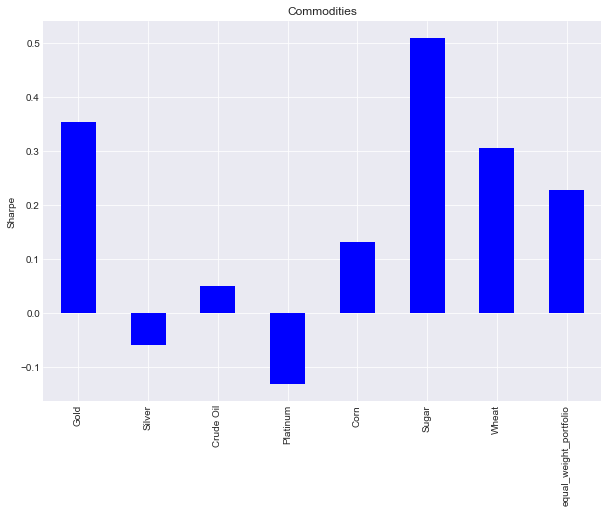

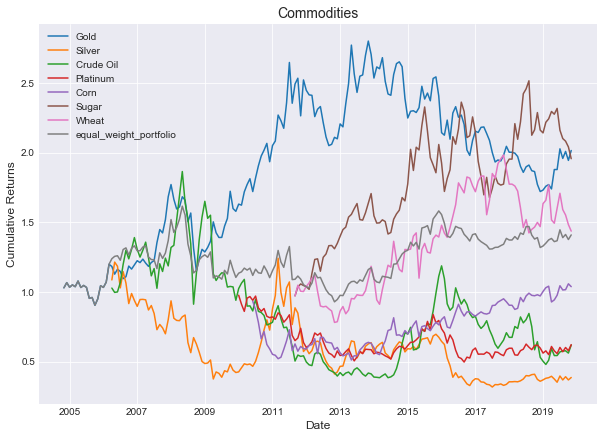

                        Annualised Returns  Annualised Volatility  \
Gold                              3.550027              17.479052   
Silver                           -4.637835              31.525508   
Crude Oil                        -2.367116              31.618620   
Platinum                         -2.343426              20.458920   
Corn                              0.183327              22.553393   
Sugar                             3.397376              19.921904   
Wheat                             1.818382              23.443311   
equal_weight_portfolio            1.721756              14.999303   

                        Max Drawdown  
Gold                      -38.570468  
Silver                    -74.465200  
Crude Oil                 -79.407674  
Platinum                  -50.368280  
Corn                      -48.899496  
Sugar                     -29.027182  
Wheat                     -30.197092  
equal_weight_portfolio    -42.516618  


In [5]:
# Import matplotlib and set the style
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

data_strategy_returns = prices[commodities].apply(
    get_ts_mom_strategy_returns, lookback=12, axis=0)*100

analytics_returns(data_strategy_returns, 'Commodities')

<a id='stocks'></a> 
## Stock indices

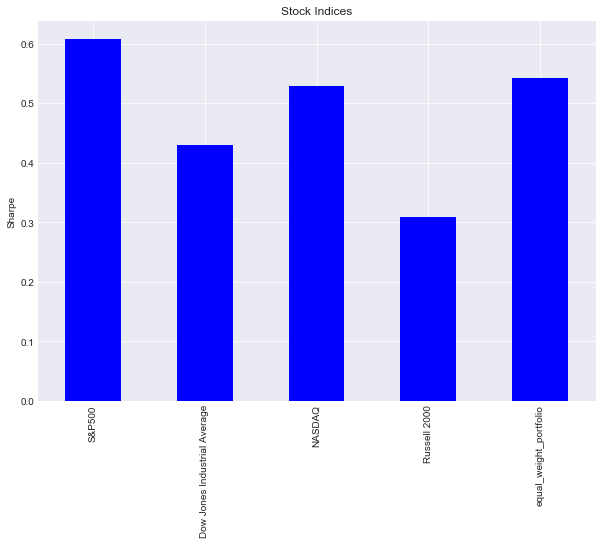

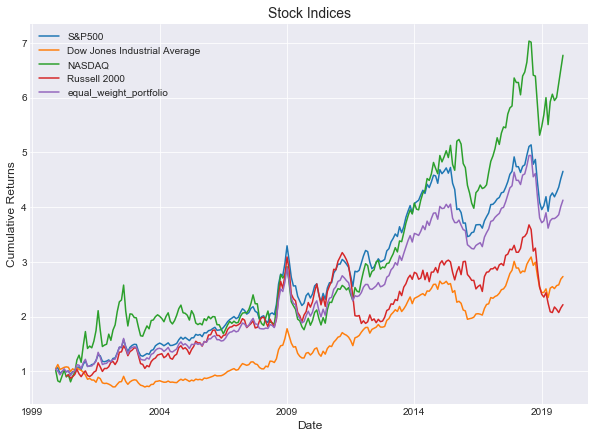

                              Annualised Returns  Annualised Volatility  \
S&P500                                  7.955372              14.364540   
Dow Jones Industrial Average            5.130848              13.984799   
NASDAQ                                  9.992149              23.250943   
Russell 2000                            4.044941              19.090433   
equal_weight_portfolio                  7.312662              15.249887   

                              Max Drawdown  
S&P500                          -33.133562  
Dow Jones Industrial Average    -36.499870  
NASDAQ                          -39.561901  
Russell 2000                    -43.585447  
equal_weight_portfolio          -34.818873  


In [6]:
data_strategy_returns = prices[stock_indices].apply(
    get_ts_mom_strategy_returns, lookback=12, axis=0)*100

analytics_returns(data_strategy_returns, 'Stock Indices')

<a id='currencies'></a> 
## Currencies

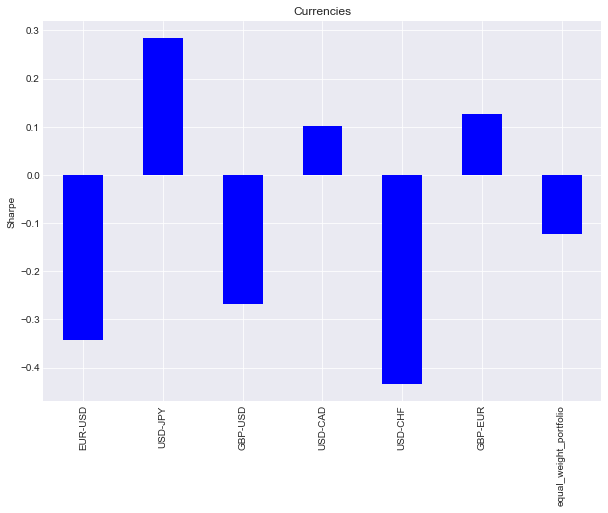

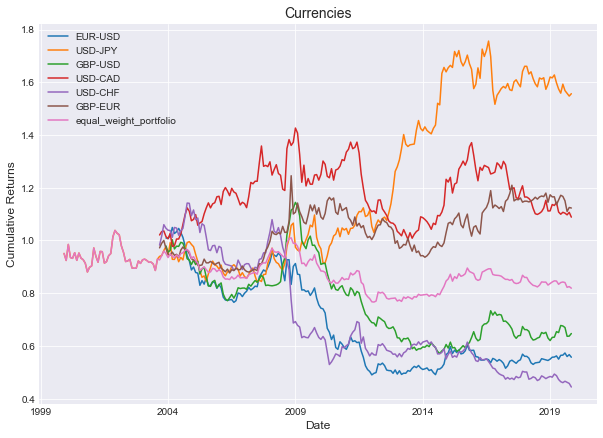

                        Annualised Returns  Annualised Volatility  \
EUR-USD                          -2.868550               9.379745   
USD-JPY                           2.228135               9.334329   
GBP-USD                          -2.143166               8.701276   
USD-CAD                           0.423586               9.168764   
USD-CHF                          -3.957587              10.235251   
GBP-EUR                           0.579959               8.519111   
equal_weight_portfolio           -0.988177               6.424469   

                        Max Drawdown  
EUR-USD                   -53.275261  
USD-JPY                   -18.915811  
GBP-USD                   -50.057051  
USD-CAD                   -29.563885  
USD-CHF                   -61.084658  
GBP-EUR                   -24.820574  
equal_weight_portfolio    -26.175492  


In [7]:
data_strategy_returns = prices[currencies].apply(
    get_ts_mom_strategy_returns, lookback=12, axis=0)*100

analytics_returns(data_strategy_returns,'Currencies')

<a id='bonds'></a> 
## Treasuries

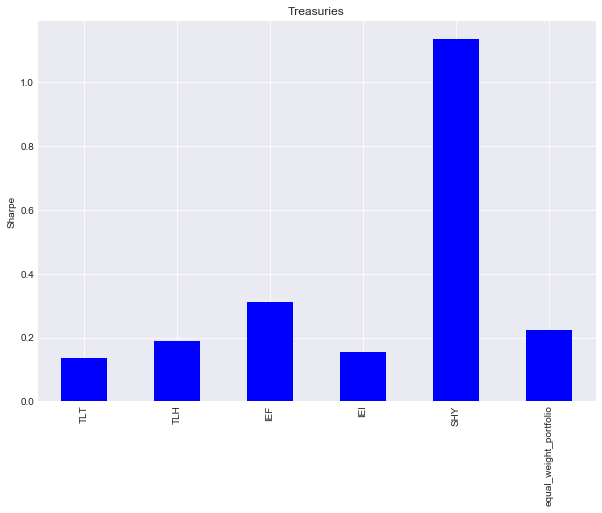

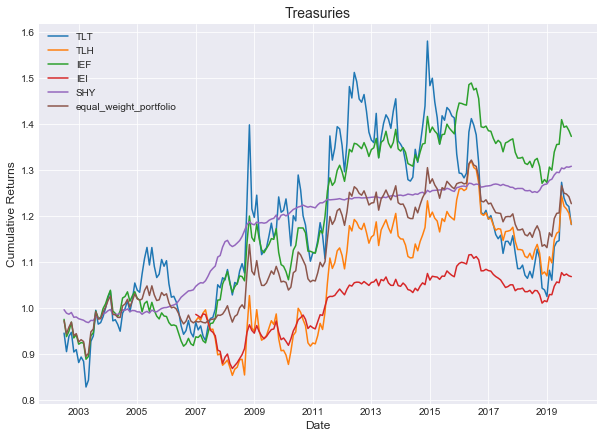

                        Annualised Returns  Annualised Volatility  \
TLT                               0.831488              13.115127   
TLH                               0.834432               8.871378   
IEF                               1.589594               6.490768   
IEI                               0.326823               3.725032   
SHY                               1.344918               1.364846   
equal_weight_portfolio            1.021395               6.037938   

                        Max Drawdown  
TLT                       -35.161082  
TLH                       -18.978424  
IEF                       -14.655894  
IEI                       -13.208394  
SHY                        -3.228317  
equal_weight_portfolio    -14.416283  


In [8]:
data_strategy_returns = prices[treasuries].apply(
    get_ts_mom_strategy_returns, lookback=12, axis=0)*100

analytics_returns(data_strategy_returns,'Treasuries')

As you can observe, the time series momentum fails for most of the securities. We have discussed the possible reasons for this failure in the previous video: 
1. Time series under observation might not be trending 
2. 12 months and 1 month might not be the optimal lookback and holding period for all securities. 

We will discuss these in great detail in the upcoming sections.<br><br>